# Simple iteration for systems of linear equations

First, generate a random diagonally dominant matrix, for testing.

In [1]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)

# I.  Jacobi iteration

Given

$$
A x = b
$$

separate the diagonal part $D$,

$$ A = D + (A - D) $$

and write

$$
x = D^{-1} (D - A) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = D^{-1} (A - D) \qquad \text{and} \qquad c = D^{-1} b
$$


Let's construct the matrix and the r.h.s. for the Jacobi iteration

In [65]:
diag_1d = np.diag(A)

B = -A.copy()
np.fill_diagonal(B, 0)

D = np.diag(diag_1d)
invD = np.diag(1./diag_1d)
BB = invD @ B 
c = invD @ b

In [66]:
# sanity checks
from numpy.testing import assert_allclose

assert_allclose(-B + D, A)


# xx is a "ground truth" solution, compute it using a direct method
xx = np.linalg.solve(A, b)

np.testing.assert_allclose(A@xx, b)
np.testing.assert_allclose(D@xx, B@xx + b)
np.testing.assert_allclose(xx, BB@xx + c)

Check that $\| B\| \leqslant 1$:

In [67]:
np.linalg.norm(BB)

11.66968152533123

### Do the Jacobi iteration

In [68]:
n_iter = 50

x0 = np.ones(n)
x = x0
for _ in range(n_iter):
    x = BB @ x + c

In [69]:
# Check the result:

A @ x - b

array([2.43707158e+47, 1.91750512e+47, 2.24353672e+47, 1.86215625e+47,
       3.24779895e+47, 3.31726063e+47, 2.71121832e+47, 2.23334258e+47,
       2.58080983e+47, 2.61281871e+47])

### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


In [70]:
  def jacobi_iteration(A, b, n_iter):
    x0 = np.ones(n)
    x = x0
    for _ in range(n_iter):
        x = BB @ x + c
    return A @ x - b, 'norm of B:', np.linalg.norm(BB)
print(jacobi_iteration(A, b, 100))


(array([1.25090044e+94, 9.84217295e+93, 1.15156284e+94, 9.55807816e+93,
       1.66703069e+94, 1.70268400e+94, 1.39161451e+94, 1.14633039e+94,
       1.32467842e+94, 1.34110795e+94]), 'norm of B:', 11.66968152533123)


Метод Якоби сходится, когда $\| B\| \leqslant 1$,

# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

In [88]:
from math import sqrt
import numpy as np

def seidels_iteration(A, b, n_iter):
    x = np.zeros(len(A))
    for i in range(n_iter):                
        for j in range(len(A)):    
            x[j] = (b[j] - A[j] @ x + A[j][j] * x[j]) / A[j][j]  # формула для итерации Зейделя
    return x

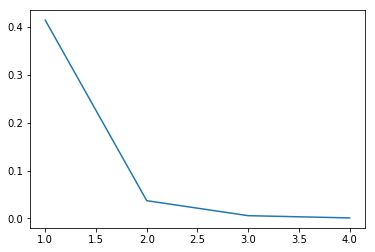

In [91]:
import matplotlib.pyplot as plt
plt.figure()
x = [i for i in range(1,5)]
plt.plot(x, [1/np.linalg.norm(A @ seidels_iteration(A, b, i) - b) for i in x]) # норма ошибки, при i числе итераций
plt.show()


# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

In [59]:
def minimum_residual(A, b, n_iter):
    
    m = A.shape[0]
    
    r = np.zeros((n_iter, m))
    t = np.zeros_like(r)
    
    x0 = np.ones(m)
    
    x_true = np.linalg.solve(A, b)
    dev = np.zeros_like(t)
    
    errors = np.zeros_like(dev)
    
    for j in range(n_iter):
        r[j] = A @ x0 - b
        t[j] = r[j].T @ (A @ r[j]) / np.linalg.norm(A @ r[j])**2
        x = x0 - t[j] * r[j]
        
        dev[j] = np.linalg.norm(x - x_true)
        
        x0 = x
        
    return x, r, t, dev

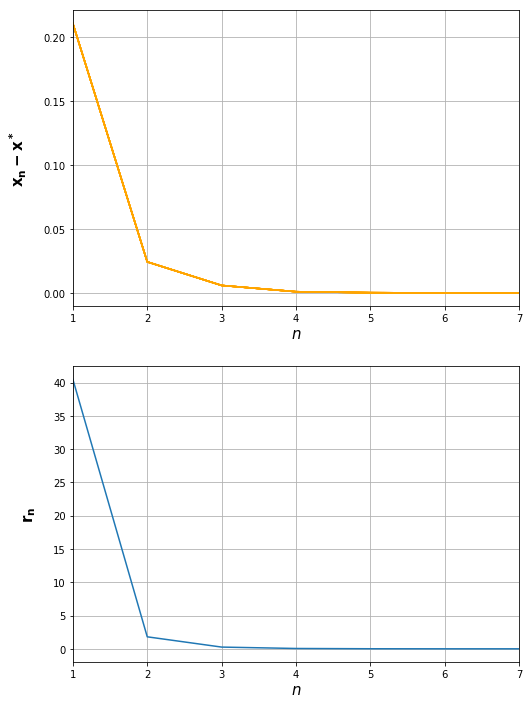

In [61]:
n_iter = 50

x, r, t, dev = minimum_residual(A_j, b, n_iter)

iterations = np.arange(1, n_iter+1)

f = plt.figure(figsize=[8, 12])
ax1 = f.add_subplot(2, 1, 1)
ax2 = f.add_subplot(2, 1, 2)

ax1.plot(iterations, dev, color='orange')
ax1.set_ylabel(r'$\mathbf{x_n - x^*}$', size=15, labelpad=15)
ax1.set_xlabel(r'$n$', size=15, labelpad=2.5)
ax1.set_xlim(1, 7)
#ax1.legend()
ax1.grid()

ax2.plot(iterations, np.linalg.norm(r, axis=1))
ax2.set_ylabel(r'$\mathbf{r_n}$', size=15, labelpad=15)
ax2.set_xlabel(r'$n$', size=15, labelpad=2.5)
ax2.set_xlim(1, 7)
#ax2.legend()
ax2.grid()

plt.show()
